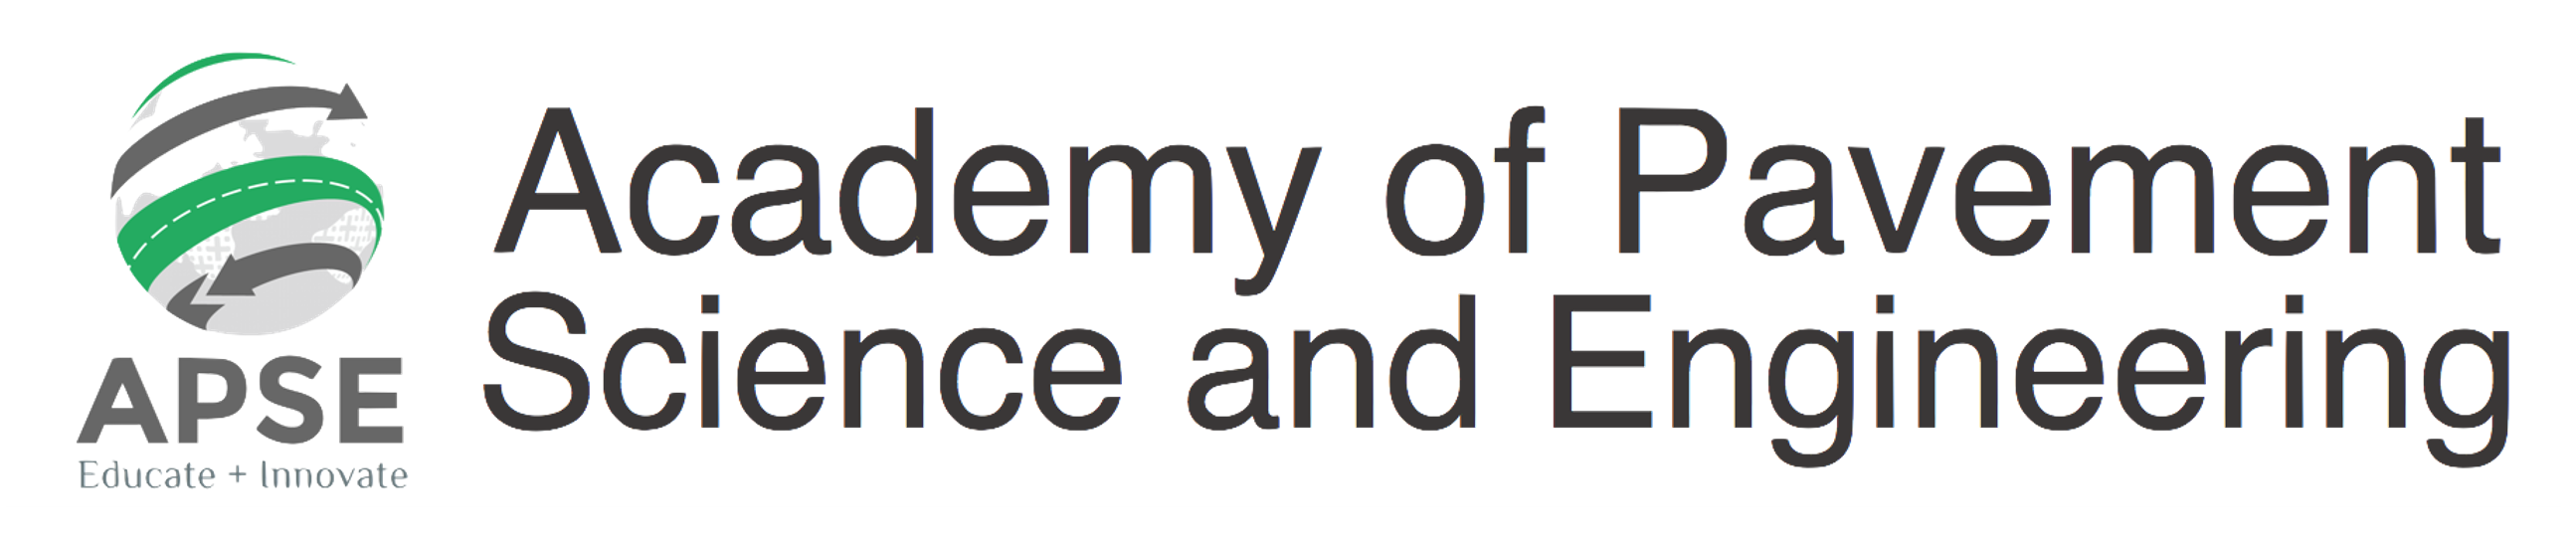

# LCCA Demo
Welcome to the LCCA demo prepared by APSE! In this example, we are going to compare two alternatives, alternative A and B for an analysis period of 40 years. We are going to conduct both probabilistic and deterministic LCCA analysis. Feel free to change any of the inputs to see the impact of them on the final results!


## Alternatives and Variables
Alternative A has 3x2in mill and overlay activities, 10 years apart and alternative B has one 2 in mill-overlay at 20 years and microsurfacing every 5 years. 


All the variables are also defined as given below. Average daily traffic, length and width of the section, Agency costs, IRI progression rate, discount rate and CPI. Probabilistic variables have distribution parameters that can be changed. Please run the cell below to load the inputs

In [ ]:
'''
Created by APSE, 2022. Instructional purposes only.
'''

#import required Python packages
import numpy as np; import pandas as pd; import seaborn as sns; import matplotlib.pyplot as plt

# Define Global Variables 
N_vehicles=20000 #number of vehicles per day
Analysis_Period=40 #40 years
IRI_0=60 #IRI value after maintenance (in/mi/year)
Length=1 #1 mile
Width=24 # 2 lanes of 12 feet
Const_Year=2022

#Alternatives assuming equal life salvage value calculation not included!
Alternatives={
'A':[[10,20,30],
       ['Overlay','Overlay','Overlay']], #Overlay at years 10,20,30
'B':[[5,10,15,20,25,30,35],
       ['MicroSurf','MicroSurf','MicroSurf','Overlay','MicroSurf','MicroSurf','MicroSurf']] 
}

#Costs [year,Distibution,mean,Dist variable 1, dist variable 2]
Costs={
'Cost_Overlay':[2017,np.random.normal,7.05,7.05,1.5], # Cost of AC in 2017,follows normal distribution with mean 64 dollar per ton = 7.05$/sqyd per 2in, std=1.5
'Cost_MicroSurf':[2015,np.random.uniform,3, 2.5,3.5], #Cost  of Microsirfacing in 2017, follows uniform distibution between 2.5-3.5 dollar per sq yard
'Cost_Fuel':[2020, np.random.uniform,4.25, 3.5,5] #cost of fuel in 2020, follows uniform distribution between 3.5 and 5 dollars per gallon
}

#IRI Progression Rate [distribution, mean, dist variable 1, dist variable 2]
IRI_Prog={
'A':[np.random.uniform,4,3,5], #rate of IRI change in/mi/year
'B':[np.random.uniform,5,4,6] #rate of IRI change in/mi/year
}

#Other variables [distribution, mean, dist variable 1, dist variable 2]
Discount_Rate=[np.random.uniform,4,3,5] #real discount rate, uniform distribution between 3-5%

#Consumer price index for every year since 2010
CPI={2010:218.05, 2011:224.94, 2012:229.59, 2013:232.96, 2014:236.736,
     2015:237.02, 2016:240.01, 2017:245.12, 2018:251.11, 2019:255.66,
     2020:258.82, 2021:270.97, 2022:282.432
}

## Agency Costs
The function below calculates the agency costs. It loops through the alternatives, then it loops through the years of maintenance and rehabilitation. For each activity, it performs inflation adjustment and discounting to calculate the present value. Please run the cell to input the function. 

For probabilistic analysis, it generates a random sample for each distribution and uses that value to calculate a random present value.

Please note! This calculation does not include remaining service life calculations. It assumes alternatives have a service life equal to analysis period. 

In [ ]:
def Agency_Cost(Deterministic=True):
    AgencyCosts={}
    for alter in Alternatives: #Do for each alternative
        PV=0 #Present value
        for index,year in enumerate(Alternatives[alter][0]): #For each year of maintenance
            Type='Cost_'+Alternatives[alter][1][index] #overlay or MicroSurf
            CPI_Corr=CPI[Const_Year]/CPI[Costs[Type][0]] #CPI correction
            if Deterministic: #For deterministic analysis, no need to sample
                Cost_At_Const=Costs[Type][2]*CPI_Corr*Width*0.33*Length*1760 #Adjust for inflation
                Dis_Rat=Discount_Rate[1]
                PV=PV+Cost_At_Const/(np.power(1+Dis_Rat/100,year)) #Discounting
            else:
                random_cost=Costs[Type][1](Costs[Type][-2],Costs[Type][-1]) #sample randomly
                Dis_Rat=Discount_Rate[0](Discount_Rate[-2],Discount_Rate[-1]) #sample randomly
                Cost_At_Const=random_cost**CPI_Corr*Width*0.33*Length*1760 #Adjust for inflation
                PV=PV+Cost_At_Const/(np.power(1+Dis_Rat/100,year)) #Discounting
                  
        AgencyCosts[alter]=PV      
        
    return AgencyCosts

## User Costs
Function below calculates additional fuel consumption due to roughness, adopted from [Ziyadi et al, 2018](https://www.sciencedirect.com/science/article/abs/pii/S0959652617325970). Similarly to agency costs, it loops through alternatives and calculates the fuel consumption at each year. It assumes that after each maintenance activity, the IRI returns to its original value. It then adjusts for inflation and discounting. 

For probabilistic analysis, it generates a random sample for each distribution and uses that value to calculate a random present value.

Please note! This calculation only includes fuel consumption due to roughness. Other costs, such as work zone delay costs are not included. 

In [ ]:
def User_Cost(Deterministic=True):
    
    def Additional_Fuel(IRI_R,t,IRI_Base,dr,cost_fuel): #(Ziyadi et al,Vehicle energy consumption and an environmental impact calculation model for the transportation infrastructure systems)
        #calculate the IRI progression difference
        C=np.insert(np.insert(np.repeat(np.array(t)*IRI_R,2),0,0),0,0) 
        B=np.append(np.insert(np.repeat(t,2),0,0),Analysis_Period)
        IRI_Progr=IRI_R*B-C
        years=np.arange(0,Analysis_Period-1,1) #discretize every year (please note, more discreteization will be more accurate)
        IRI_P=np.interp(years, B, IRI_Progr)
        #calculate additional fuel cost due to additional roughness
        FuelCost=2.0469*(0*1242.78 + IRI_P)/131/1000*cost_fuel/(np.power(1+dr/100,years)) #discounting
        Costtotal=np.trapz(FuelCost,x=years)*Length #integrate to find the total
        return Costtotal
    
    UserCosts={}
    for alter in Alternatives: #for each alternative
        PV=0 #Present value
        years=Alternatives[alter][0] #years of maintenance
        CPI_Corr=CPI[Const_Year]/CPI[Costs['Cost_Fuel'][0]] #CPI correction
        if Deterministic: #if deterministic analysis, no need to sample
            fuelcost=Costs['Cost_Fuel'][2] #dollar per gallon
            Dis_Rat=Discount_Rate[1] #discount rate
            costperveh=Additional_Fuel(IRI_Prog[alter][1],years,IRI_0,Dis_Rat,fuelcost) #calculate cost per vehicle (discounted)
            Cost_At_Const=costperveh*N_vehicles*365*CPI_Corr #Adjust for CPI
            PV=PV+Cost_At_Const
        else:
            IRI_R=IRI_Prog[alter][0](IRI_Prog[alter][-2],IRI_Prog[alter][-1]) #randomly sample IRI progression rate
            fuelcost=Costs['Cost_Fuel'][1](Costs['Cost_Fuel'][-2],Costs['Cost_Fuel'][-1]) #randomly sample fuel cost
            Dis_Rat=Discount_Rate[0](Discount_Rate[-2],Discount_Rate[-1]) #sample discount rate
            costperveh=Additional_Fuel(IRI_R,years,IRI_0,Dis_Rat,fuelcost) #calculate cost per vehicle (discounted)
            Cost_At_Const=costperveh*N_vehicles*365*CPI_Corr #adjust for inflation
            PV=PV+Cost_At_Const
        UserCosts[alter]=PV  
    return UserCosts

## Deterministic Analysis
Deterministic Analysis will use the mean values of the variables to generate the agency and user costs. Please run the cell below to see the results

In [ ]:
# Deterministic Agency Cost
CostDF=pd.DataFrame(columns=['Agency Cost (Const Year $M)'],index=['A','B'])
AC=Agency_Cost(); CostDF.iloc[0,:]=AC['A']/10**6; CostDF.iloc[1,:]=AC['B']/10**6 #cost in million dollars
#Deterministic User Cost
UC=User_Cost()
CostDF['User Cost (Const Year $M)']=np.array(list(UC.values()))/10**6
CostDF

,Agency Cost (Const Year $M),User Cost (Const Year $M)
A,0.163082,0.175915
B,0.200648,0.101438


## Probabilistic Analysis
For probabilistic analysis, we have to generate multiple realizations of costs. In this demo, we will use Monte Carlo (MC) simulations. Latin Hypercube sampling is another popular sampling method. An important convergence criteria is the coefficient of variation to ensure that sampling yields accurate results

In [ ]:
N=1000 #number of simulations

Prob_Cost=pd.DataFrame(np.zeros([N,4]),columns=['Agency_A','Agency_B','User_A','User_B'])

Ag_A=[];Ag_B=[];Us_A=[];Us_B=[]
for i in range(N): #do analysis N times
    CC=Agency_Cost(False); Ag_A.append(CC['A']/10**6); Ag_B.append(CC['B']/10**6)
    CC=User_Cost(False);   Us_A.append(CC['A']/10**6); Us_B.append(CC['B']/10**6)  
Prob_Cost['Agency_A']=Ag_A; Prob_Cost['Agency_B']=Ag_B; Prob_Cost['User_A']=Us_A; Prob_Cost['User_B']=Us_B

print('Coefficient of Variation for MC simulations (smaller the better)')
print((Prob_Cost.std()/np.sqrt(N))/Prob_Cost.mean())

Coefficient of Variation for MC simulations (smaller the better)
Agency_A    0.004944
Agency_B    0.002767
User_A      0.006277
User_B      0.005622
dtype: float64


## Plotting the Results
We can plot the distribution of agency and user costs.  We will plot the probability density function (pdf) for each and cumulative density function (cdf) of the total cost that tells us the probability of exceeding a given cost. 

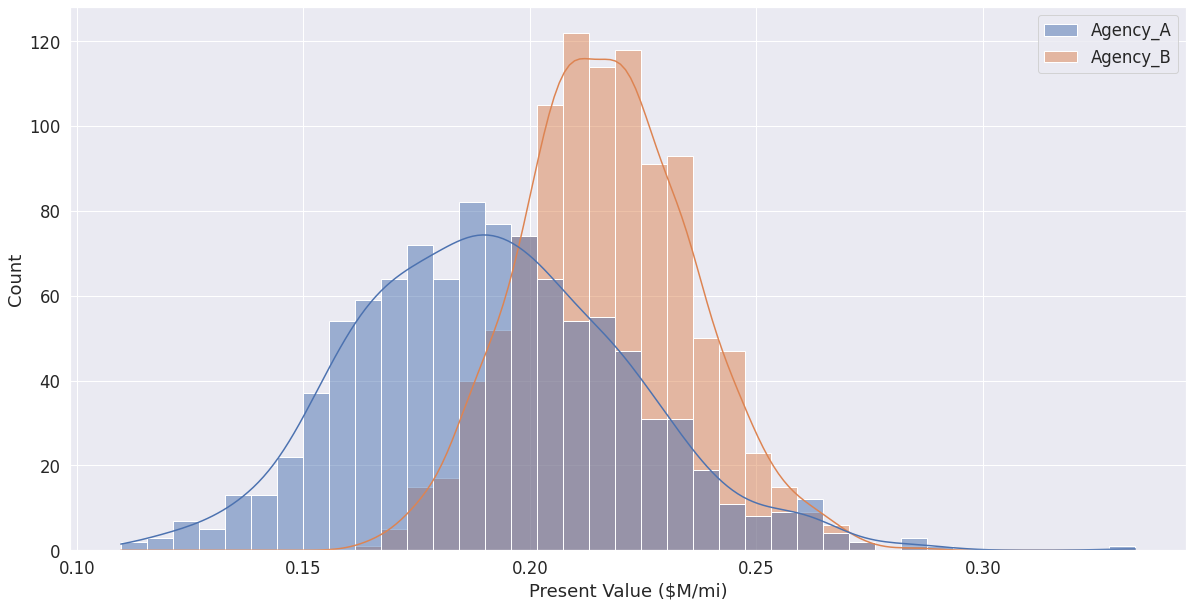

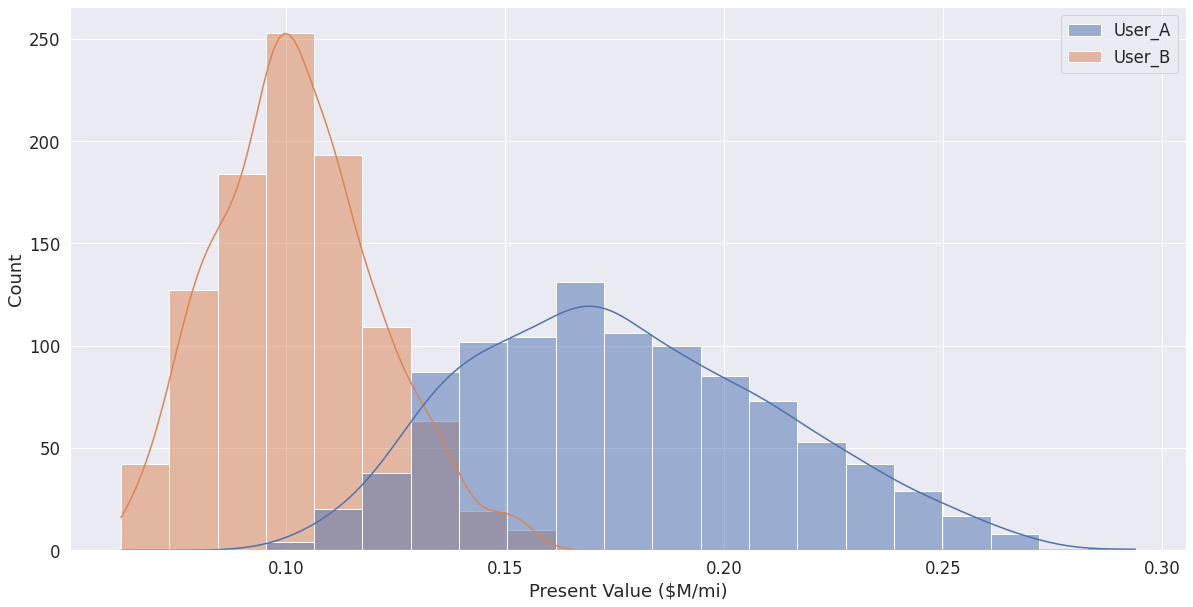

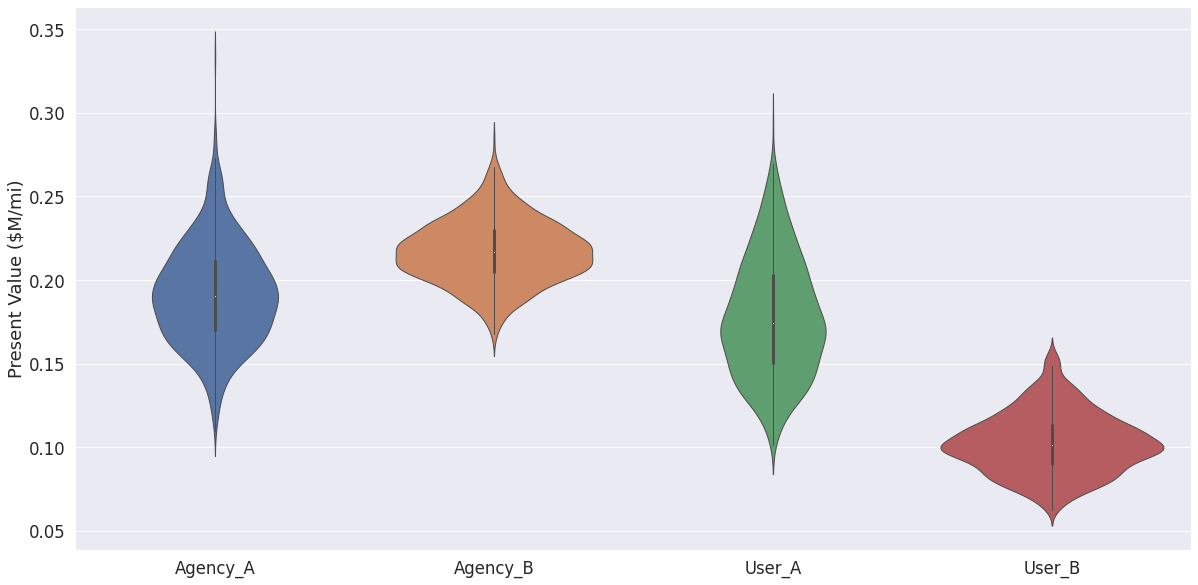

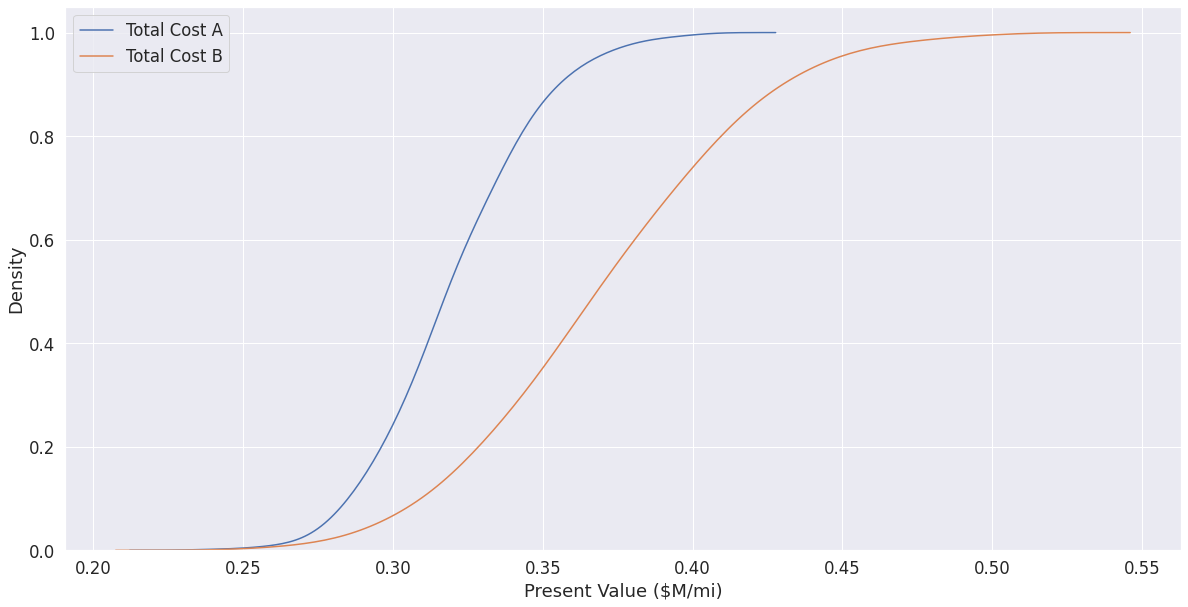

In [ ]:
plt.close('all')
sns.set(font_scale=1.5,rc={'figure.figsize':(20,10)})
plt.figure()
sns.histplot(Prob_Cost.iloc[:,:2],kde=True)
plt.xlabel('Present Value ($M/mi)')
plt.figure()
sns.histplot(Prob_Cost.iloc[:,2:],kde=True)
plt.xlabel('Present Value ($M/mi)')
plt.figure()
sns.violinplot(data=Prob_Cost,inner='box',linewidth=1)
plt.ylabel('Present Value ($M/mi)')
plt.figure()
sns.kdeplot(Prob_Cost.iloc[:,0]+Prob_Cost.iloc[:,2],cumulative=True,label='Total Cost A')
sns.kdeplot(Prob_Cost.iloc[:,1]+Prob_Cost.iloc[:,3],cumulative=True,label='Total Cost B')
plt.xlabel('Present Value ($M/mi)')
plt.ylabel('Probability')
plt.legend()